In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scp


In [2]:
!pip install cvxpy

  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/38/85/5f46779431dd978f62a1f5bd64df05d9a1418cc50d7294e98bf445e31068/cvxpy-1.4.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for osqp>=0.6.2 from https://files.pythonhosted.org/packages/23/46/232041be3d85624ec4c20b3bdb8bd4bfb6640851901db155917e0c412aef/osqp-0.6.3-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/72.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/72.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/72.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/72.0 kB ? eta -:--:--
     ---------------------- ----------------- 41.0/72.0 kB ? eta -:--:--
     ---------------------- ----------------- 41.0/72.0 kB ? eta -:--:--
     -------------------------------------- 72.0/72.0 kB 494.4 kB/s eta 0:00:00
  Obtaining dependency information for clarabel>=0.5.0 from https://files

In [3]:
#Paramètres

np.random.seed(1)

n =  700

#Définitions des seuils p = a/n > q= b/n (a-b)^2 >= epsilon^(-2) 484 *g (1) thm 1.3 p5 (voir après pour les valeurs de a et b qui satisfont (1))
p = 670/700
q =  10/700
l = 0


Jn = np.ones((n,n))
#Définition de la matrice Z à estimer

Z = np.random.choice([0, 1], size=(n, n))

for i in range(n) :
  for j in range(n) :
    Z[i][j] = Z[j][i]

for i in range(n) :
  Z[i][i] = 1




#Tuning parameter

for i in range(n) :
  for j in range(n) :
    l += Z[i][j]



#Calcul de la matrice d'adjacence à partir des tirages de p et de q
A = np.zeros((n,n))

#Définition de la matrice A observée (peut être choisir ensuite pij selon la valeur de pbarre)

for i in range(n):
  for j in range(n) :
    if (Z[i][j] == 0) :
      A[i][j] = np.random.choice([0,1],p = [1 -p,p])
      A[i][j] = A[j][i]
    else :
      A[i][j] = np.random.choice([0,1],p = [1 -q,q])
      A[i][j] = A[j][i]

for i in range(n) :
  A[i][i] = 1
#Matrice de référence E(A) = (p+q)Jn (voir après pour rajouter une matrice de pij ?)

R = (p+q)*np.ones((n,n))


C = []
b = []
for i in range(n):
    b.append(1)



# Define and solve the CVXPY problem.
# Create a symmetric matrix variable.
X = cp.Variable((n,n), symmetric=True)
# The operator >> denotes matrix inequality.
constraints = [X >> 0]
#constraints += [
#    cp.trace(C[i] @ X) <= b[i] for i in range(n)
#]
constraints += [
    cp.diag(X) <= np.ones(n)
]


constraints += [
    cp.sum(X) == l
]





In [4]:
#Optimisation avec le solver CVXPY sur le problème 6.2 p 19 (E(A) au lieu de A)


def optimisationCVXref(p,q) :
  A  = np.zeros((n,n))

  #Recalcul de R
  R = (p+q)*np.ones((n,n))
  constraints = [X >> 0]

  constraints += [
    cp.diag(X) <= np.ones(n)
  ]



  constraints += [
    cp.sum(X) == l
  ]


  prob = cp.Problem(cp.Minimize(cp.trace(R @ X)),constraints)
  prob.solve()
  return X.value


In [7]:
#Essai pour une valeur de p et de q
prob = cp.Problem(cp.Minimize(cp.trace(A @ X)),constraints)
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)
print(Z)

The optimal value is 351.2542294482863
A solution X is
[[0.50179176 0.50179184 0.50179184 ... 0.50179184 0.50179184 0.50179184]
 [0.50179184 0.50179176 0.50179184 ... 0.50179184 0.50179184 0.50179184]
 [0.50179184 0.50179184 0.50179176 ... 0.50179184 0.50179184 0.50179184]
 ...
 [0.50179184 0.50179184 0.50179184 ... 0.50179176 0.50179184 0.50179184]
 [0.50179184 0.50179184 0.50179184 ... 0.50179184 0.50179176 0.50179184]
 [0.50179184 0.50179184 0.50179184 ... 0.50179184 0.50179184 0.50179176]]
[[1 0 0 ... 0 0 0]
 [0 1 1 ... 0 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 0 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 0 1 ... 0 0 1]]


In [9]:
constraints2 = [X >> 0]

constraints2 += [
    cp.diag(X) == np.ones(n)
  ]



constraints2 += [
    cp.sum(X) == l
  ]

In [10]:
#Essai avec un resserrement de la contrainte diag(X) <= In
prob = cp.Problem(cp.Minimize(cp.trace(A @ X)),constraints2)
prob.solve()

700.0000000000055

In [11]:
X.value

array([[1.        , 0.50107909, 0.50107909, ..., 0.50107909, 0.50107909,
        0.50107909],
       [0.50107909, 1.        , 0.50107909, ..., 0.50107909, 0.50107909,
        0.50107909],
       [0.50107909, 0.50107909, 1.        , ..., 0.50107909, 0.50107909,
        0.50107909],
       ...,
       [0.50107909, 0.50107909, 0.50107909, ..., 1.        , 0.50107909,
        0.50107909],
       [0.50107909, 0.50107909, 0.50107909, ..., 0.50107909, 1.        ,
        0.50107909],
       [0.50107909, 0.50107909, 0.50107909, ..., 0.50107909, 0.50107909,
        1.        ]])

In [4]:
#Optimisation avec le solver CVXPY sur le problème 1.10


def optimisationCVX(p,q) :
  A  = np.zeros((n,n))

#Définition de la matrice A observée

  for i in range(n):
    for j in range(n) :
      if (Z[i][j] == 0) : A[i][j] = np.random.choice([0,1],p = [1 -p,p])
      else : A[i][j] = np.random.choice([0,1],p = [1 -q,q])
      A[i][j] = A[j][i]
  X = cp.Variable((n,n), symmetric=True)
# The operator >> denotes matrix inequality.
  constraints = [X >> 0]
#constraints += [
#    cp.trace(C[i] @ X) <= b[i] for i in range(n)
#]
  constraints += [
    cp.diag(X) <= np.ones(n)
  ]


  constraints += [
    cp.sum(X) == l
  ]


  prob = cp.Problem(cp.Minimize(cp.trace(A @ X)),constraints)
  prob.solve()
  return X.value




In [5]:
#Boucle sur les valeurs de a/n à 1 sur le problème 1.10 p4
a=670
#optimisationCVX(0.86,0.004)
liste1 = np.linspace(a/n, 1, 20)
m = len(liste1)
erreurs = np.zeros(m)
i = 0

for p in liste1 :
  erreurs[i] = np.linalg.norm(optimisationCVX(p,q)-Z,"fro")
  i = i+1



Text(0.5, 1.0, "Evolution de l'erreur en fonction de p")

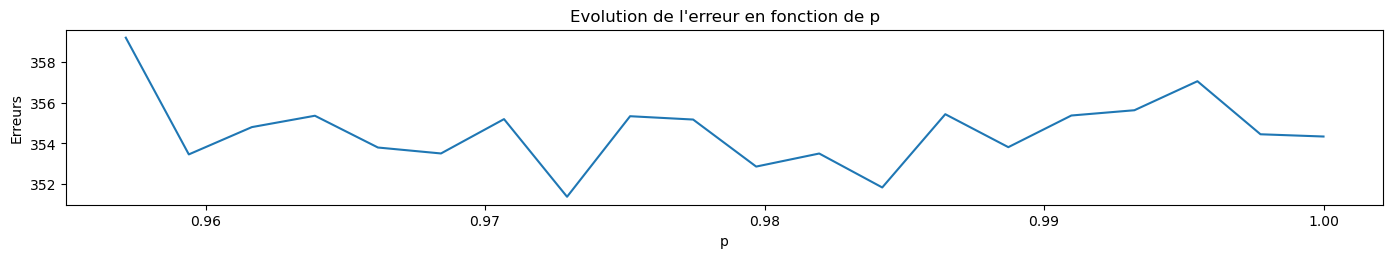

In [6]:
plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.plot(liste1, erreurs)
plt.xlabel('p')
plt.ylabel("Erreurs")
plt.title("Evolution de l'erreur en fonction de p")

In [ ]:
#Calculs précédents insérés dans une fonction
MAX_ITERS = 100

def caculeVecteurXioptimal(i) :
  x = cp.Variable(shape=n)
  f = cp.matmul(cp.transpose(A)[i,:], x)
  # Constraints
  constraints2 = [

    cp.sum(x) <= l
   ]



  M = np.zeros((n,n))
  M[i][i] = 1

  b = cp.Parameter(shape = (n))
  b.value = np.zeros(n)
  b.value[0] = 1

  # Solve with method of multipliers.
  resid = cp.matmul(M, x) - b
  y = cp.Parameter(shape=(n))
  y.value = np.zeros(n)

  # Augmented Lagrangian
  aug_lagr = f + cp.matmul(cp.transpose(y), resid) + (rho/2) * cp.sum_squares(resid)

  for t in range(MAX_ITERS):
    problem_multipliers = cp.Problem(cp.Minimize(aug_lagr),constraints2)
    problem_multipliers.solve()

    # Check if the problem is feasible
    if problem_multipliers.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        print("The problem is not feasible.")
        break
    print("resid:", resid)
    # Update Lagrange multiplier
    y.value += rho * (resid.value if resid.value is not None else np.zeros(n))

# Get the optimal solution
  optimal_x = x.value
  return optimal_x

optimal_x = caculeVecteurXioptimal(1)
print("Optimal x from method of multipliers: {}".format(optimal_x))


The problem is not feasible.
Optimal x from method of multipliers: None


/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [ ]:
#Calculs avec scipy
results = []
rho = 1
def calculate_optimal_x(i):
    # Initialisation de la variable
    z = np.ones(n)

    # Initialisation du multiplicateur de Lagrange
    y = np.zeros(n)

    # Matrice M
    M = np.zeros((n, n))
    M[i][i] = 1


    # Contraintes du problème primaire
    constraints = [

        {'type': 'eq', 'fun': lambda x: -np.sum(x) + l},


        {'type': 'ineq', 'fun': lambda x: x}
    ]
    resid = M@z - b
    objective = lambda z : np.dot(A[:, i],z) + np.dot(y, resid) + (rho / 2) * np.sum(resid**2)
    xold = np.zeros(n)
    for t in range(n):


        # Mise à jour de la variable optimale

        xopt = scp.minimize(objective, xold, constraints=constraints).x

        y +=  rho * resid
        results.append(xopt)
        print(xopt)
        xold = xopt
    return results





In [ ]:
calculate_optimal_x(1)

[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -6.41708908e-14
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -6.47260023e-14 -5.81756865e-14]
[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -6.41708908e-14
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -6.47260023e-14 -5.81756865e-14]
[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -6.41708908e-14
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -6.47260023e-14 -5.81756865e-14]
[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -6.41708908e-14
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -6.47260023e-14 -5.81756865e-14]
[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -6.41708908e-14
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -6.47260023e-14 -5.81756865e-14]
[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -6.41708908e-14
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -6.47260023e-14 -5.81756865e-14]
[ 8.14285714e+00

[array([ 8.14285714e+00,  8.14285714e+00,  8.14285714e+00, -6.41708908e-14,
         8.14285714e+00,  8.14285714e+00,  8.14285714e+00,  8.14285714e+00,
        -6.47260023e-14, -5.81756865e-14]),
 array([ 8.14285714e+00,  8.14285714e+00,  8.14285714e+00, -6.41708908e-14,
         8.14285714e+00,  8.14285714e+00,  8.14285714e+00,  8.14285714e+00,
        -6.47260023e-14, -5.81756865e-14]),
 array([ 8.14285714e+00,  8.14285714e+00,  8.14285714e+00, -6.41708908e-14,
         8.14285714e+00,  8.14285714e+00,  8.14285714e+00,  8.14285714e+00,
        -6.47260023e-14, -5.81756865e-14]),
 array([ 8.14285714e+00,  8.14285714e+00,  8.14285714e+00, -6.41708908e-14,
         8.14285714e+00,  8.14285714e+00,  8.14285714e+00,  8.14285714e+00,
        -6.47260023e-14, -5.81756865e-14]),
 array([ 8.14285714e+00,  8.14285714e+00,  8.14285714e+00, -6.41708908e-14,
         8.14285714e+00,  8.14285714e+00,  8.14285714e+00,  8.14285714e+00,
        -6.47260023e-14, -5.81756865e-14]),
 array([ 8.14285714e

In [ ]:
#Essai d'optimisation à chaque étape avec a et b qui varient

In [ ]:
#Calcul des résultats à chaque itération
for i in range(n) :
  results = calculate_optimal_x(i)
results



[1.42500000e+01 6.12843110e-14 5.37347944e-14 5.81756865e-14
 1.42500000e+01 5.41788836e-14 5.90638649e-14 1.42500000e+01
 1.42500000e+01 5.59552404e-14]
[1.42500000e+01 6.12843110e-14 5.37347944e-14 5.81756865e-14
 1.42500000e+01 5.41788836e-14 5.90638649e-14 1.42500000e+01
 1.42500000e+01 5.59552404e-14]
[1.42500000e+01 6.12843110e-14 5.37347944e-14 5.81756865e-14
 1.42500000e+01 5.41788836e-14 5.90638649e-14 1.42500000e+01
 1.42500000e+01 5.59552404e-14]
[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -2.22044605e-16
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -2.66453526e-15 -3.21964677e-15]
[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -2.22044605e-16
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -2.66453526e-15 -3.21964677e-15]
[ 8.14285714e+00  8.14285714e+00  8.14285714e+00 -2.22044605e-16
  8.14285714e+00  8.14285714e+00  8.14285714e+00  8.14285714e+00
 -2.66453526e-15 -3.21964677e-15]
[-2.59792188e-14 -2.62012634e-14  9.50000000e+

[array([1.42500000e+01, 6.12843110e-14, 5.37347944e-14, 5.81756865e-14,
        1.42500000e+01, 5.41788836e-14, 5.90638649e-14, 1.42500000e+01,
        1.42500000e+01, 5.59552404e-14]),
 array([1.42500000e+01, 6.12843110e-14, 5.37347944e-14, 5.81756865e-14,
        1.42500000e+01, 5.41788836e-14, 5.90638649e-14, 1.42500000e+01,
        1.42500000e+01, 5.59552404e-14]),
 array([1.42500000e+01, 6.12843110e-14, 5.37347944e-14, 5.81756865e-14,
        1.42500000e+01, 5.41788836e-14, 5.90638649e-14, 1.42500000e+01,
        1.42500000e+01, 5.59552404e-14]),
 array([ 8.14285714e+00,  8.14285714e+00,  8.14285714e+00, -2.22044605e-16,
         8.14285714e+00,  8.14285714e+00,  8.14285714e+00,  8.14285714e+00,
        -2.66453526e-15, -3.21964677e-15]),
 array([ 8.14285714e+00,  8.14285714e+00,  8.14285714e+00, -2.22044605e-16,
         8.14285714e+00,  8.14285714e+00,  8.14285714e+00,  8.14285714e+00,
        -2.66453526e-15, -3.21964677e-15]),
 array([ 8.14285714e+00,  8.14285714e+00,  8.14285

In [ ]:
#Récupération des calculs de la matrice optimale à toutes les itérations
Xoptim = np.zeros((n,n*MAX_ITERS))

for k in range(n):
  j=0
  for i in range(MAX_ITERS) :
    Xoptim[:,j+k] = results[i+k*MAX_ITERS]
    j = j+MAX_ITERS

Xoptim[:,29]

IndexError: index 1000 is out of bounds for axis 1 with size 1000

In [ ]:
A

array([[0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 0., 1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 0., 0., 1., 0.]])

In [ ]:
#Calcul des erreurs à chaque iterations
erreurs = np.zeros(MAX_ITERS)


for i in range(MAX_ITERS):
  M = Xoptim[:,i*n:(i+1)*n]
  erreurs[i] = np.linalg.norm(M - Z,ord="fro")
#print(np.linalg.norm((Xoptim[:,4*n:(4+1)*n] - Z),ord='fro'))
erreurs

array([8.73276605, 8.73276605, 8.73276605, 8.73276605, 8.73276605,
       8.73276605, 8.73276605, 8.73276605, 8.73276605, 8.73276605])

In [ ]:
#Essai ADMM

M = -np.transpose(A)
phik = np.zeros(n)
zk = np.zeros(n)
gamma = 1/2
#Norme carrée MC

lambda v : np.linalg.norm(M@v - gamma*phik - )